In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import math
import cv2
import torch

In [103]:
N  = 100
channels = 6
# 光学参数
anglepara = 0.33
theta = np.linspace(-np.pi*anglepara,np.pi*anglepara,channels) # 折射角度
lambdad = 532e-9
pitch = 400e-9
d = 40e-6
L = N * pitch
k0 = 2*np.pi / lambdad

dphi = pitch * np.sin(theta) * k0 # 相位梯度

x = np.linspace(-1/2*L,1/2*L,N)
y = np.linspace(-1/2*L,1/2*L,N)
X,Y=np.meshgrid(x,y)

phase =  np.zeros([N,channels]) # N*M

# 求解每个通道下超原子对应的相位,理想相位
for i in range(channels):
    phase[:,i] = x / pitch * dphi[i]%(2*np.pi)

AT = np.array([np.cos(theta)**2,np.sin(2*theta),np.sin(theta)**2])
A =  np.transpose(AT)
a1 = np.linalg.inv(np.dot(AT,A))
AI = np.dot(a1,AT)

E = np.dot(AI,np.transpose(np.exp(1j*phase)))
O=np.dot(A,E)
#plt.plot(np.transpose(phase))
sigma = 0.7
Noise = np.dot(A,sigma*np.random.randn(3,N))
#O = O + Noise
err=np.abs(O-np.transpose(np.exp(1j*phase)))

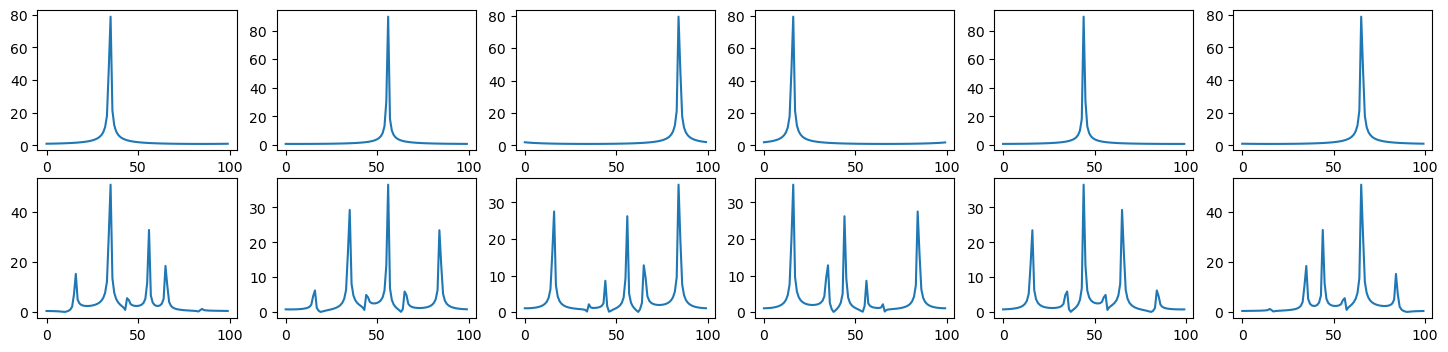

In [104]:
fig, axs = plt.subplots( 2,channels,figsize=(18,4))
images = []
for i in range (channels):
    images.append(axs[0][i].plot(np.abs(np.fft.fft(np.exp(1j*phase[:,i])))))
    images.append(axs[1][i].plot(np.abs(np.fft.fft(O[i,:]))))
plt.show()

In [105]:
def MSE(pred,target):
    return (np.sum((target - pred) ** 2)/len(target))

loss = MSE(np.abs(np.fft.fft(np.transpose(np.exp(1j*phase)))),np.abs(np.fft.fft(O)))
print(loss)


4518.027856988959


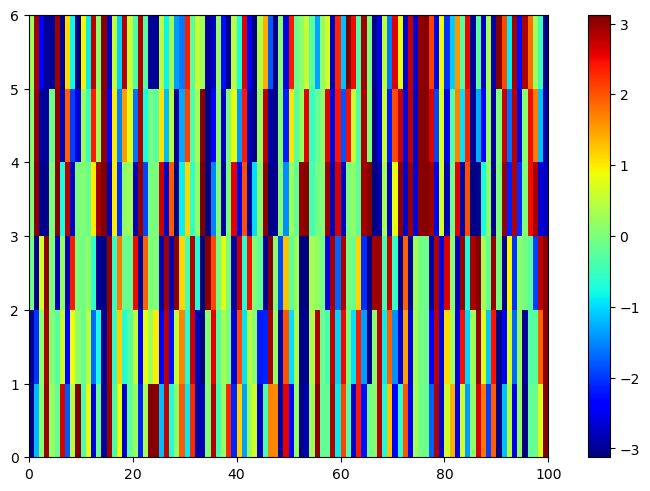

In [98]:
jet = cm.get_cmap('jet')
fig, axs = plt.subplots(1, 1,constrained_layout=True, squeeze=False)
for [ax, cmap] in zip(axs.flat, [jet]):
    psm = ax.pcolormesh(np.angle(O), cmap=cmap, rasterized=True)
    fig.colorbar(psm, ax=ax)
plt.show()

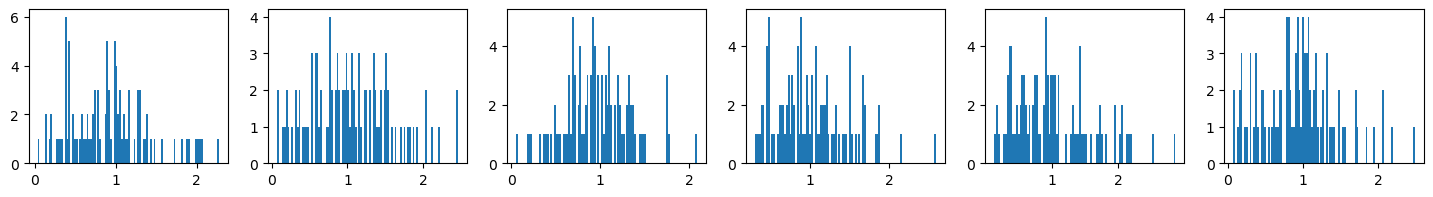

In [99]:
fig, axs = plt.subplots(1,channels,figsize=(18,2))
images = []
for i in range (channels):
    images.append(axs[i].hist(err[i,:],bins = 100))
plt.show()

In [100]:
# 角谱法
def AS_Propagation(Uin,z,lambdad,L):
    
    nx = Uin.shape[0]
    ny = Uin.shape[1]
    x = np.linspace(-nx//2,nx//2-1,nx)
    y = np.linspace(-ny//2,ny//2-1,ny)
    X,Y=np.meshgrid(x,y)
    fx = X/L
    fy = Y/L
    k = 2*np.pi/lambdad
    q = fx**2 + fy**2
    H = np.exp(1.0j*k*z*np.sqrt(1-(lambdad**2)*q))
    O = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))
    U = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(H*O)))
    
    return U


(100, 100)


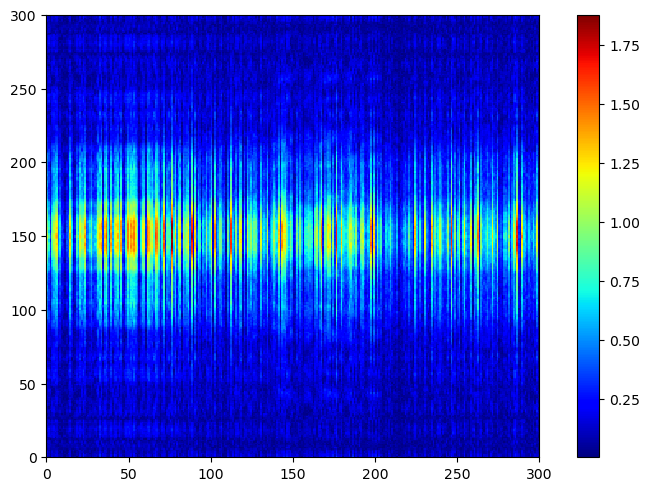

In [101]:
Oin = O[5,:].reshape(1,N)#O[1,:].reshape(1,N)#np.exp(1j*phase[:,0]).reshape(1,N)
Oin = np.repeat(Oin,N,axis = 0)
print(Oin.shape)
padnum = 100
Oin = np.pad(Oin,[(padnum,padnum),(padnum,padnum)],'constant')

out = AS_Propagation(Oin,1e-3,lambdad,Oin.shape[0]*pitch)
jet = cm.get_cmap('jet')

fig, axs = plt.subplots(1, 1,constrained_layout=True, squeeze=False)
for [ax, cmap] in zip(axs.flat, [jet]):
    psm = ax.pcolormesh(np.abs(out), cmap=cmap, rasterized=True)
    fig.colorbar(psm, ax=ax)
plt.show()



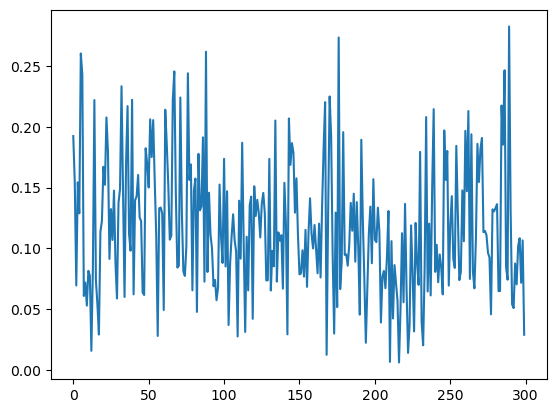

In [102]:
plt.plot(np.abs(out[50,:]))